# Local testing

I copied a nc file and track file to this directory.

In [1]:
import numpy as np
import xarray as xr

import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Read one forecast file

In [2]:
#ds = xr.open_dataset('/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/nc/nepartak11w.2021072718.f030.nc')
ds = xr.open_dataset('nepartak11w.2021072718.f030.nc')
ds

<xarray.Dataset>
Dimensions:              (latitude: 601, longitude: 601, time: 1)
Coordinates:
  * latitude             (latitude) float64 36.95 36.97 36.98 ... 45.94 45.95
  * longitude            (longitude) float64 131.5 131.5 131.5 ... 140.5 140.5
  * time                 (time) datetime64[ns] 2021-07-29
Data variables:
    PRMSL_meansealevel   (time, latitude, longitude) float32 ...
    PRES_surface         (time, latitude, longitude) float32 ...
    UGRD_10maboveground  (time, latitude, longitude) float32 ...
    VGRD_10maboveground  (time, latitude, longitude) float32 ...
    PRATE_surface        (time, latitude, longitude) float32 ...
    APCP_surface         (time, latitude, longitude) float32 ...
    ACPCP_surface        (time, latitude, longitude) float32 ...
    NCPCP_surface        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:          COARDS
    History:              created by wgrib2
    GRIB2_grid_template:  0

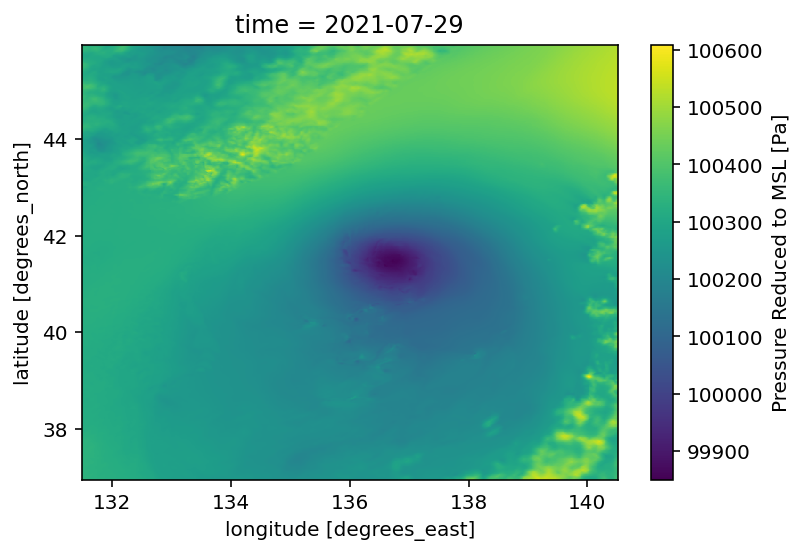

In [3]:
ds.PRMSL_meansealevel.plot();

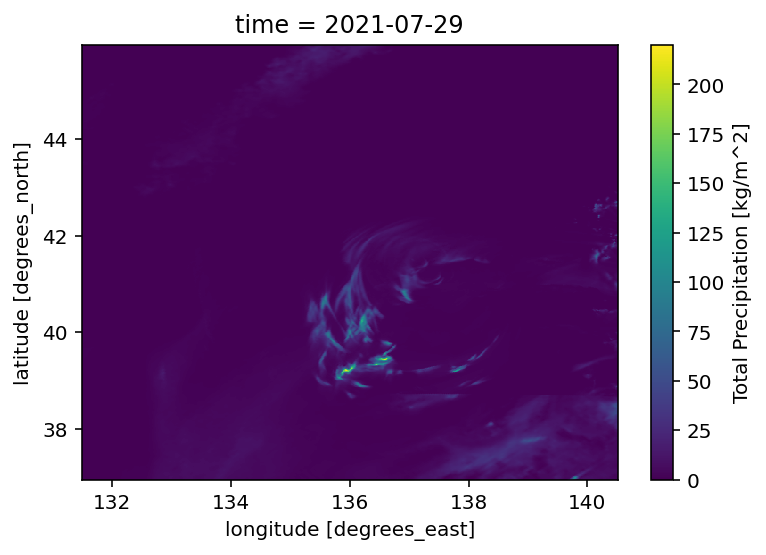

In [4]:
ds.APCP_surface.plot();

# Read tpc file
With center etc

`0         1         2         3         4         5         6         7         8         9         0`

`0123456789012345678901234567890123456789012345678901234567890123456789012345678901234567890123456789`

`HOUR:   0.0  LONG:  142.00  LAT:  37.80  MIN PRES (hPa):  985.00   MAX SURF WIND (KNOTS):  41.00    `

In [5]:
import pandas as pd
colspecs = [(5, 10), (18, 25), (32, 38), (56, 63), (89, 95)]
# df = pd.read_fwf('/data2/qy2216/HWRF_wind/hwrf.2021072718/nepartak11w/track/NEPARTAK11W.2021072718.stats.tpc', 
df = pd.read_fwf('NEPARTAK11W.2021072718.stats.tpc', 
                 colspecs=colspecs, header=None, skiprows=12, names=['hour', 'lon', 'lat', 'P', 'V'])
df = df[:41]
df.head()

,hour,lon,lat,P,V
0,0.,142.0,37.8,985.0,41.0
1,3.,141.8,38.4,992.0,43.0
2,6.,141.6,38.9,994.0,39.0
3,9.,141.2,39.7,997.0,34.0
4,12.,140.7,40.4,997.0,29.0


In [6]:
# they are strings, convert to float
df['hour'] = df['hour'].astype(float)
df['lat'] = df['lat'].astype(float)
df['lon'] = df['lon'].astype(float)

xcenter = df[df.hour == 30].lon.values[0]
ycenter = df[df.hour == 30].lat.values[0]

print(xcenter, ycenter)

136.8 41.4


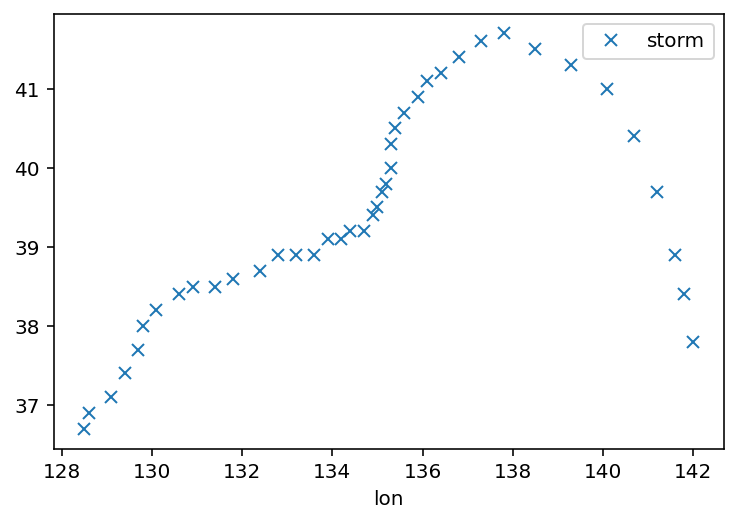

In [7]:
df.plot(x='lon', y='lat', style='x', label='storm')
plt.show()

# Start plotting

Strategy
1. Define storm-centered polar coordinate grid
2. Convert lat-lon to km
    - Use cosine of center lat value
    - Use cosine of lat values <- sensible
    - Use catopy

## Original (lat-lon)

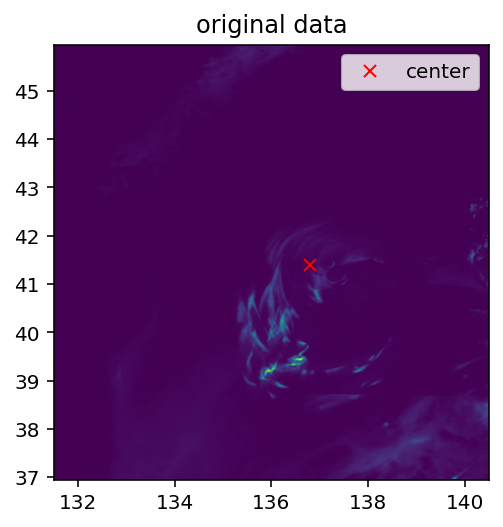

In [8]:
#z = ds.PRMSL_meansealevel.isel(time=0).values
z = ds.APCP_surface.isel(time=0).values

lon = ds.longitude.values
lat = ds.latitude.values

plt.pcolormesh(lon, lat, z, shading='gouraud')
plt.title('original data')
plt.gca().set_aspect('equal')
plt.plot(xcenter, ycenter, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

## Storm-centered polar coordinate grid

In [9]:
# new polar coordinates that are uniform in r and theta
# units of r are km

ntheta_pts = 201
nr_pts = 200
rmax = 300

#FIX rmax name
r1 = np.linspace(0, rmax, nr_pts)
theta1 = np.linspace(-np.pi, np.pi, ntheta_pts)

theta2, r2 = np.meshgrid(theta1, r1)

# cartesian coordinates (in km) of the polar coordinates
polar_x2 = r2 * np.cos(theta2)
polar_y2 = r2 * np.sin(theta2)
polar_x2.shape

(200, 201)

## Cosine lat weighting (center value)

In [10]:
np.cos(np.deg2rad(ycenter))

0.7501110696304596

number of grid points (361201, 2) 361201


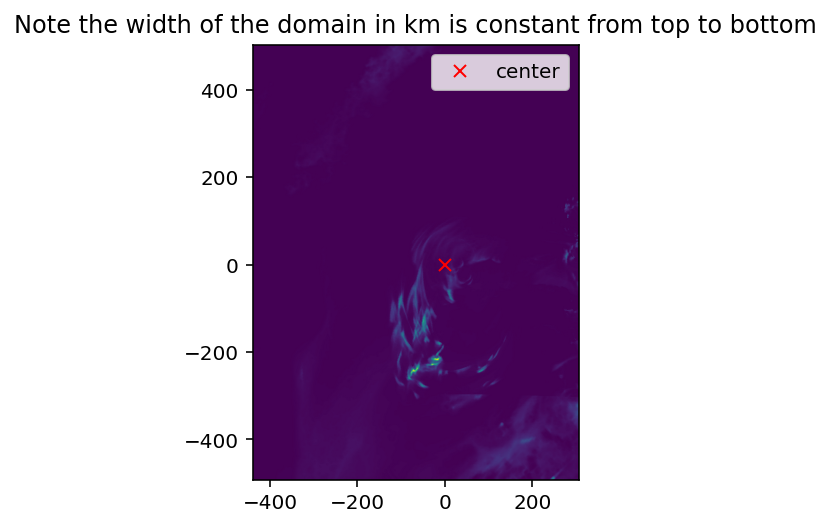

In [11]:
# uses one cos lat value for scaling
# units are km
x1 = (ds.longitude.values - xcenter) * np.cos(np.deg2rad(ycenter)) * 110.567
y1 = (ds.latitude.values - ycenter) * 110.567
x2, y2 = np.meshgrid(x1, y1)

# number of points X 2 matrix of x y
xy = np.stack((x2.flatten(), y2.flatten())).T
print('number of grid points', xy.shape, 601 * 601)

plt.pcolormesh(x1, y1, z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Note the width of the domain in km is constant from top to bottom')
plt.show()

In [12]:
from scipy.interpolate import NearestNDInterpolator
#from scipy.interpolate import LinearNDInterpolator
#interp = LinearNDInterpolator(xy, z.flatten())
interp = NearestNDInterpolator(xy, z.flatten())

In [13]:
# z interpolated to the uniform polar coordinate locations
Z = interp(polar_x2, polar_y2)

In [14]:
Z.shape

(200, 201)

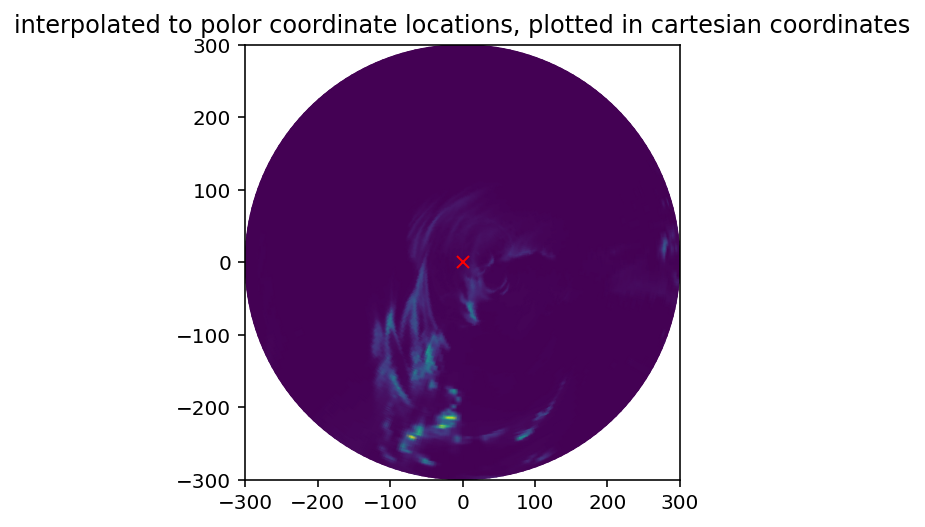

In [15]:
plt.pcolormesh(polar_x2, polar_y2, Z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.title('interpolated to polor coordinate locations, plotted in cartesian coordinates');

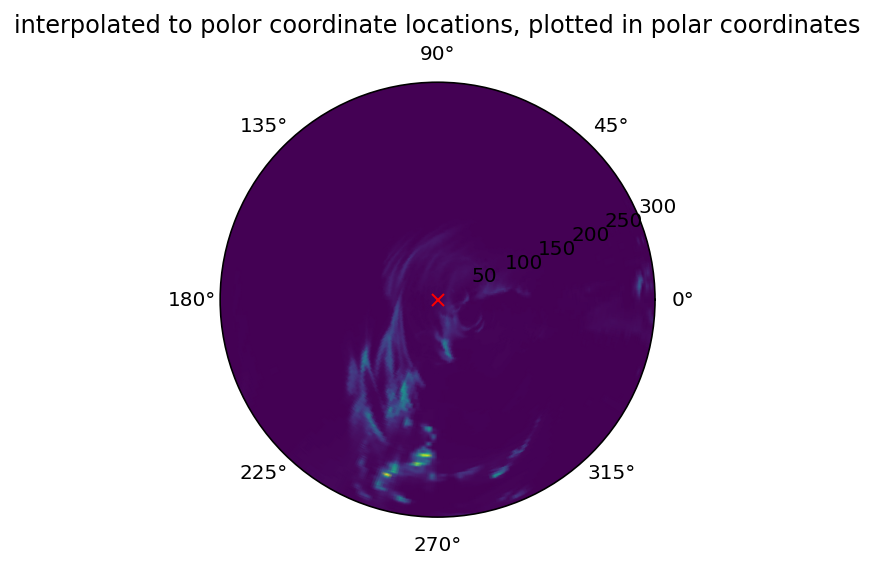

In [16]:
plt.subplot(projection="polar")
plt.pcolormesh(theta1, r1, Z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.title('interpolated to polor coordinate locations, plotted in polar coordinates')
plt.show()

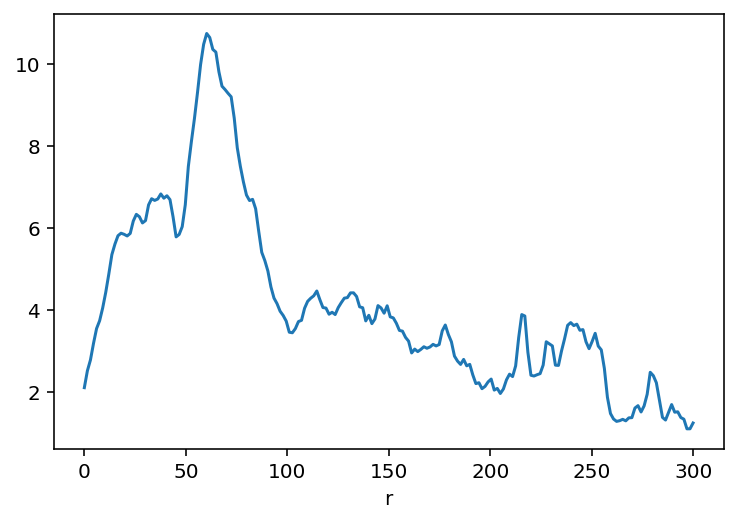

In [17]:
plt.plot(r1, np.mean(Z, axis=1))
plt.xlabel('r')
plt.show()

In [18]:
# rename result to compare latter
Z_center = Z

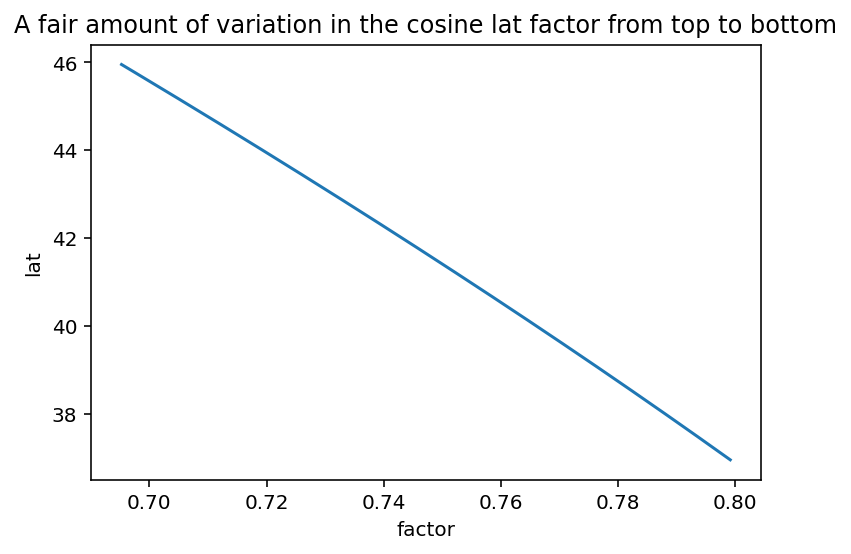

In [19]:
plt.plot(np.cos(np.deg2rad(ds.latitude.values)), lat)
plt.title('A fair amount of variation in the cosine lat factor from top to bottom')
plt.xlabel('factor')
plt.ylabel('lat')
plt.show()

## Cosine lat weighting (varying)

In [20]:
# uses all the cos lat values km/deg = 110.567 
x1 = (ds.longitude.values - xcenter) * 110.567
y1 = (ds.latitude.values - ycenter) * 110.567
x2, y2 = np.meshgrid(x1, y1)

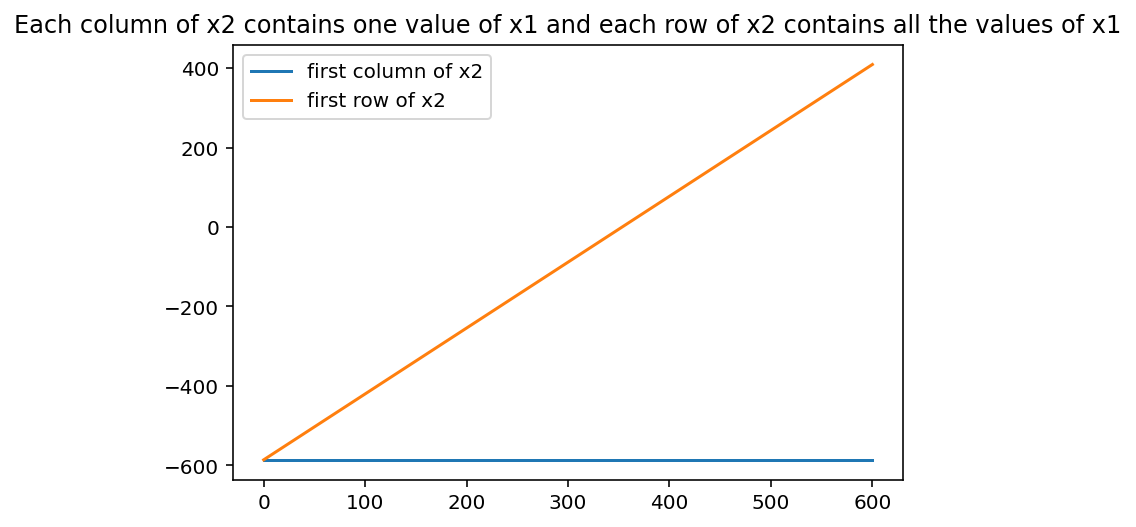

In [21]:
plt.plot(x2[:, 0], label='first column of x2')
plt.plot(x2[0, :], label='first row of x2')
plt.title('Each column of x2 contains one value of x1 and each row of x2 contains all the values of x1')
plt.legend()
plt.show()

In [22]:
# choose the shape of the factor to broadcast along the 2nd 
cosine_factor = np.cos(np.deg2rad(ds.latitude.values)).reshape(-1, 1)
x2 = cosine_factor * x2

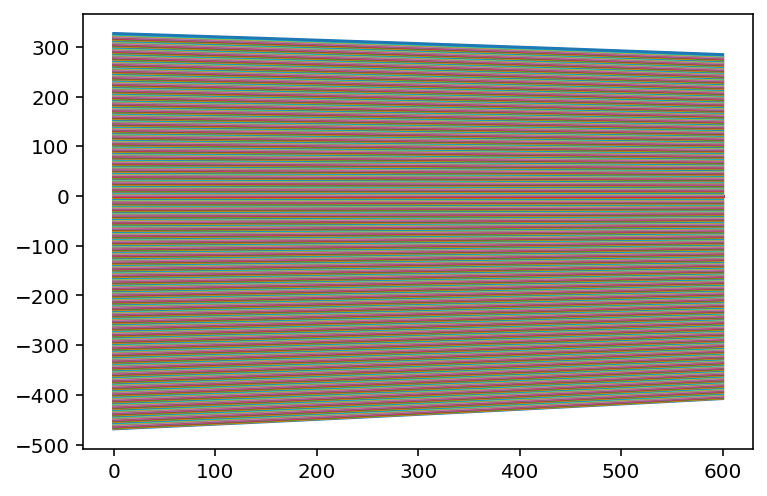

In [23]:
plt.plot(x2);

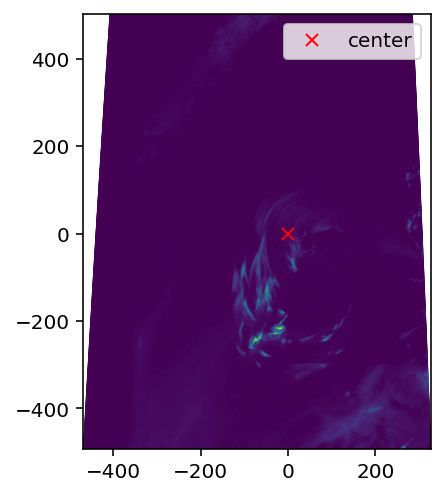

In [24]:
plt.pcolormesh(x2, y2, z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [25]:
# number of points X 2 matrix of x y
xy = np.stack((x2.flatten(), y2.flatten())).T
xy.shape

(361201, 2)

In [26]:
from scipy.interpolate import NearestNDInterpolator
#from scipy.interpolate import LinearNDInterpolator
#interp = LinearNDInterpolator(xy, z.flatten())
interp = NearestNDInterpolator(xy, z.flatten())

In [27]:
# z interpolated to the uniform polar coordinate locations
Z = interp(polar_x2, polar_y2)

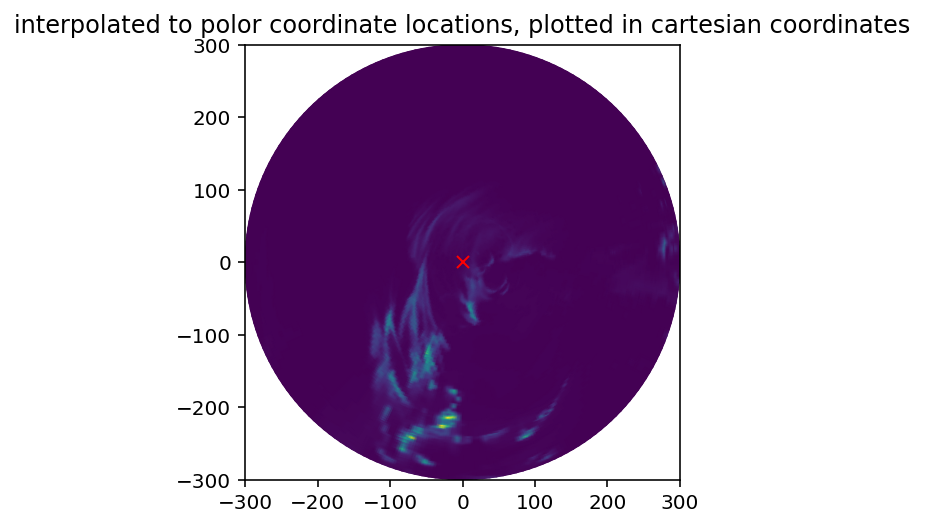

In [28]:
plt.pcolormesh(polar_x2, polar_y2, Z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.title('interpolated to polor coordinate locations, plotted in cartesian coordinates');

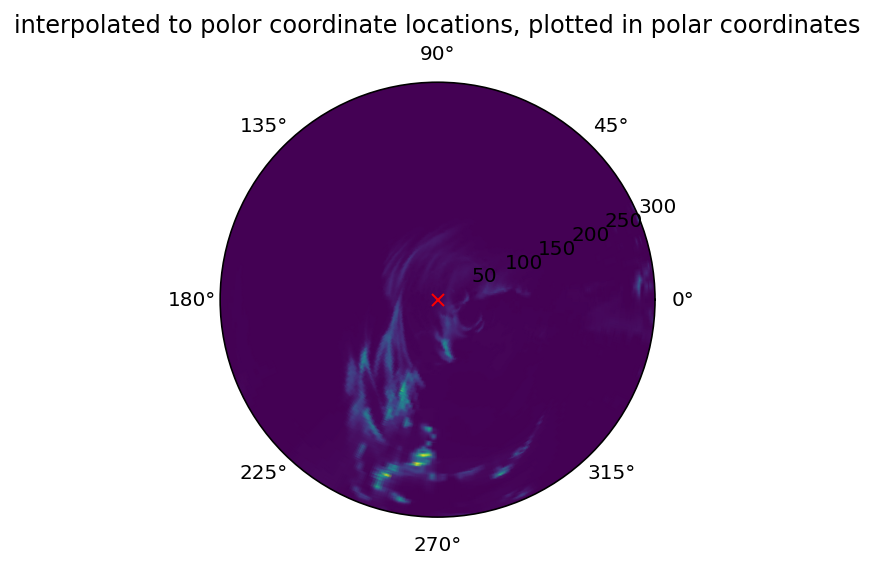

In [29]:
plt.subplot(projection="polar")
plt.pcolormesh(theta1, r1, Z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.title('interpolated to polor coordinate locations, plotted in polar coordinates')
plt.show()

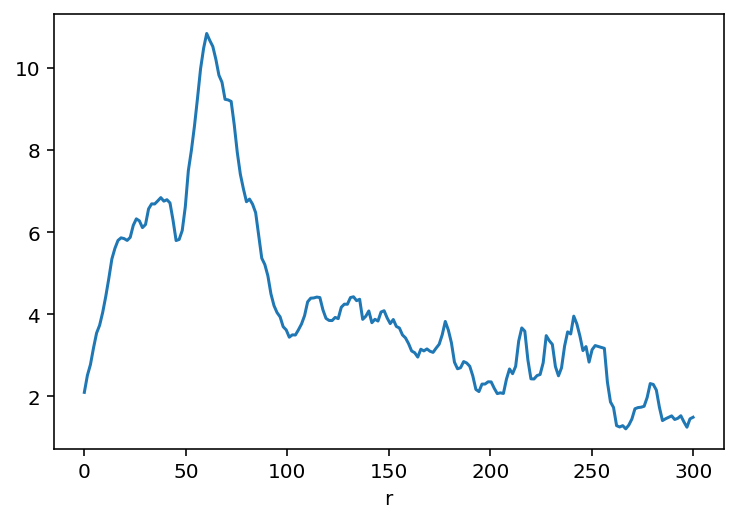

In [30]:
plt.plot(r1, np.mean(Z, axis=1))
plt.xlabel('r')
plt.show()

In [31]:
# rename result to compare latter
Z_varying = Z

## Cartopy

In [32]:
import cartopy.crs as ccrs

proj_local = ccrs.TransverseMercator(central_longitude=xcenter, central_latitude=ycenter, approx=False)
#proj_local = ccrs.AzimuthalEquidistant(central_longitude=xcenter, central_latitude=ycenter)

proj_data = ccrs.PlateCarree() 

# define point
p_data = (xcenter, ycenter)

# convert from data to cartesian coordinates
p_local = proj_local.transform_point(*p_data, src_crs=proj_data)

print(p_local)

(0.0, 0.0)


In [33]:
# number of points X 2 matrix of x y
lon2, lat2 = np.meshgrid(lon, lat)
lonlat = np.stack((lon2.flatten(), lat2.flatten())).T

In [34]:
x2 = np.empty_like(lon2)
y2 = np.empty_like(lat2)

for ii in range(0, len(lon)):
    for jj in range(0, len(lon)):
        x2[ii, jj], y2[ii, jj] = proj_local.transform_point(lon2[ii, jj], lat2[ii, jj], src_crs=proj_data)
# m -> km
x2, y2 = x2/1000, y2/1000

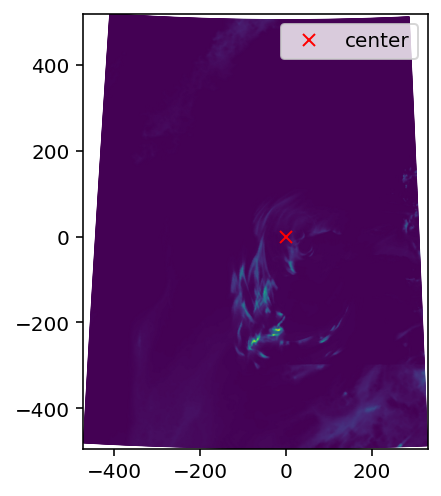

In [35]:
plt.pcolormesh(x2, y2, z, shading='gouraud')
plt.plot(0, 0, 'rx', label='center')
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

In [36]:
# number of points X 2 matrix of x y
xy = np.stack((x2.flatten(), y2.flatten())).T
xy.shape

(361201, 2)

In [37]:
#from scipy.interpolate import LinearNDInterpolator
#interp = LinearNDInterpolator(xy, z.flatten())
from scipy.interpolate import NearestNDInterpolator
interp = NearestNDInterpolator(xy, z.flatten())

In [38]:
# z interpolated to the uniform polar coordinate locations
Z = interp(polar_x2, polar_y2)

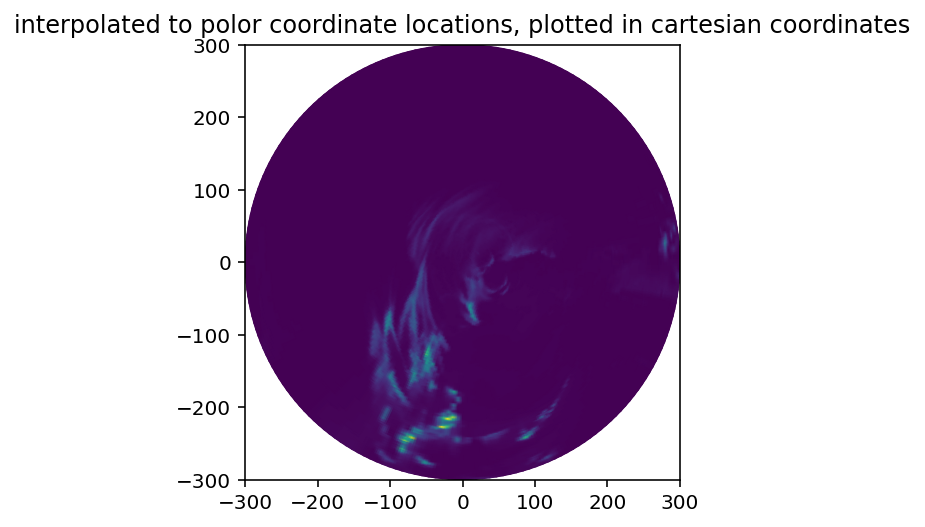

In [39]:
plt.pcolormesh(polar_x2, polar_y2, Z, shading='gouraud')
plt.gca().set_aspect('equal')
plt.title('interpolated to polor coordinate locations, plotted in cartesian coordinates');

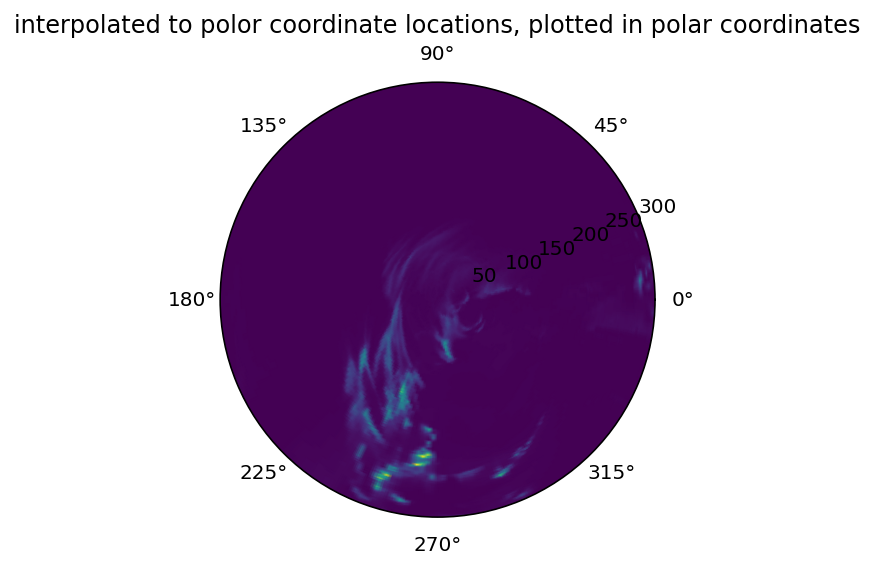

In [40]:
plt.subplot(projection="polar")
plt.pcolormesh(theta1, r1, Z, shading='gouraud')
plt.title('interpolated to polor coordinate locations, plotted in polar coordinates')
plt.show()

In [41]:
# rename result to compare latter
Z_proj = Z

# Compare

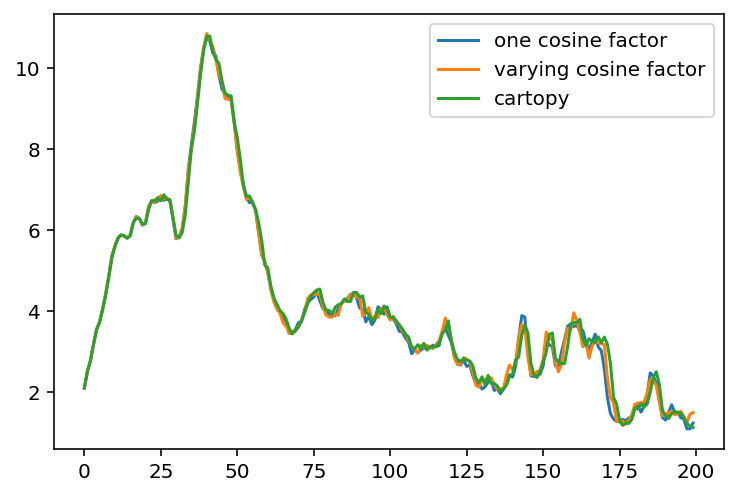

In [42]:
plt.plot(np.mean(Z_center, axis=1), label='one cosine factor')
plt.plot(np.mean(Z_varying, axis=1), label='varying cosine factor')
plt.plot(np.mean(Z_proj, axis=1), label='cartopy')
plt.legend()
plt.show()

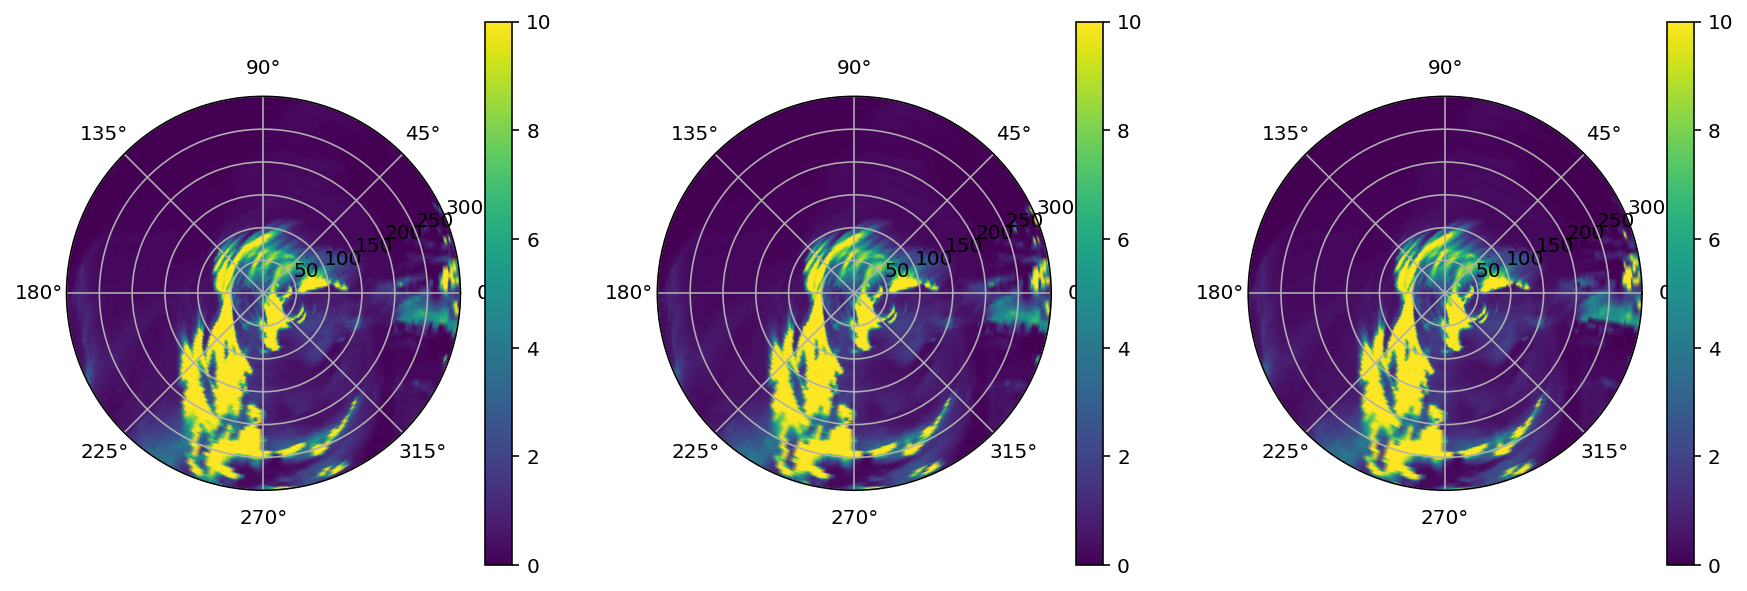

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))

ax = axs[0]
g = ax.pcolormesh(theta1, r1, Z_center, vmax=10, shading='gouraud')
plt.colorbar(g, ax=ax)
ax.grid()

ax = axs[1]
g = ax.pcolormesh(theta1, r1, Z_varying, vmax=10, shading='gouraud')
plt.colorbar(g, ax=ax)
ax.grid()

ax = axs[2]
g = axs[2].pcolormesh(theta1, r1, Z_proj, vmax=10, shading='gouraud')
plt.colorbar(g, ax=ax)
ax.grid()

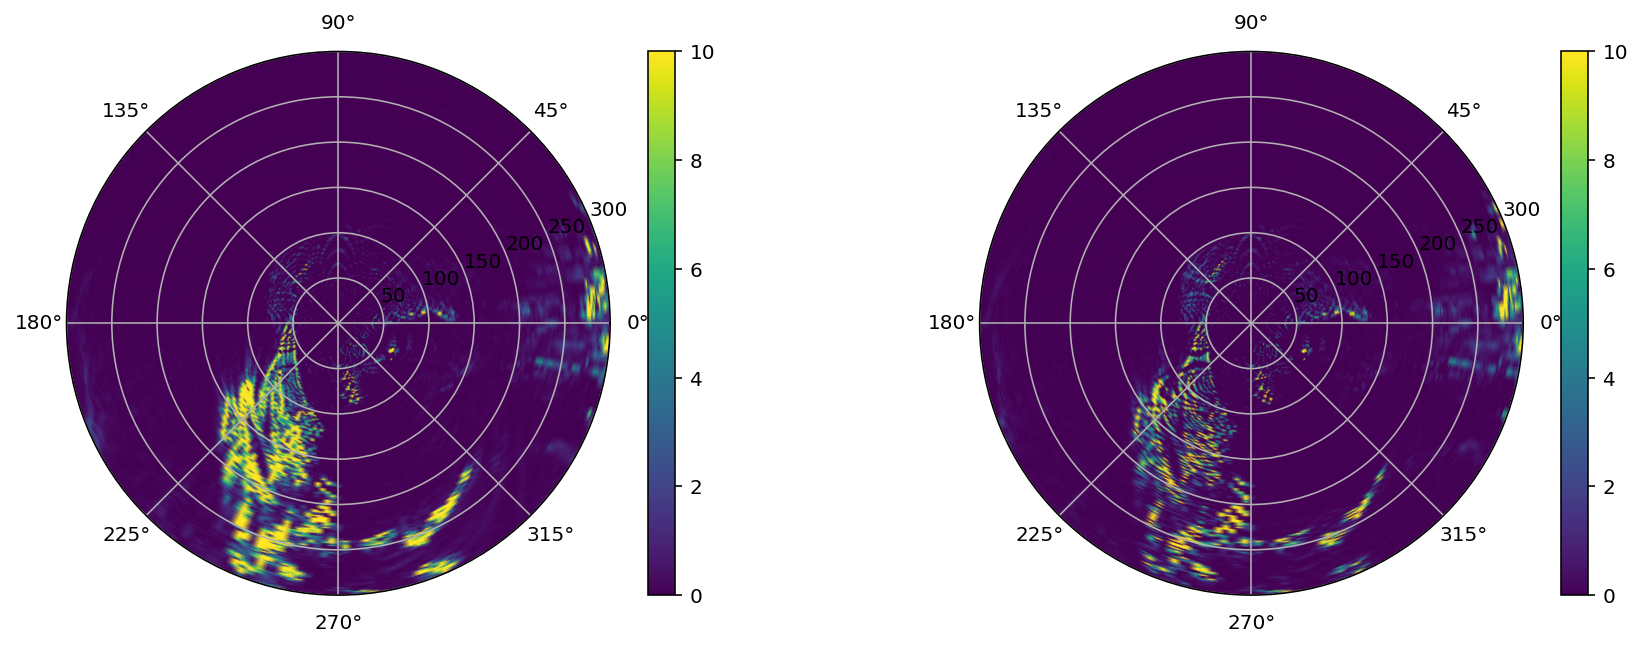

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw=dict(polar=True))

ax = axs[0]
g = ax.pcolormesh(theta1, r1, np.abs(Z_center - Z_proj), vmax=10, shading='gouraud')
plt.colorbar(g, ax=ax)
ax.grid()

ax = axs[1]
g = ax.pcolormesh(theta1, r1, np.abs(Z_varying - Z_proj), vmax=10, shading='gouraud')
plt.colorbar(g, ax=ax)
ax.grid()